In [134]:
import os
import re
import json
from typing_extensions import List, TypedDict, Annotated
from dotenv import load_dotenv
import operator

from langchain_openai import ChatOpenAI
from langchain_openai import OpenAIEmbeddings

from langchain_chroma import Chroma


from langchain.vectorstores import DocArrayInMemorySearch
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.messages import SystemMessage, AnyMessage
from langchain_core.prompts import PromptTemplate
from langchain_core.documents import Document
from langchain_core.output_parsers import StrOutputParser
from langchain_core.tools import tool

from langgraph.graph import START, END, StateGraph, MessagesState, add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import Send

from pydantic import BaseModel, Field


load_dotenv()

True

In [148]:
class OverallState(MessagesState):
    responses: Annotated[List[AnyMessage], operator.add]
    combined_response: str

class SubGraphState(MessagesState):
    response: AnyMessage


def extract_json_output(response: str):
    json_match = re.search(r"<output>(.*?)</output>", response, re.DOTALL)
    json_string = json_match.group(1).strip()
    parsed_json = json.loads(json_string)
    return parsed_json
    
def extract_str_output(response: str):
    str_match = re.search(r"<output>(.*?)</output>", response, re.DOTALL)
    str_string = str_match.group(1).strip()
    return str_string

llm = ChatOpenAI(model="gpt-4o-mini", api_key=os.getenv("OPENAI_API_KEY"))
embeddings = OpenAIEmbeddings(model="text-embedding-3-large", api_key=os.getenv("OPENAI_API_KEY"))
loader = PyPDFLoader(file_path="data/AML_IEEE_ACCESS_2024.pdf", extract_images=True)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=150)

docs = loader.load()
all_splits = text_splitter.split_documents(docs)
db = DocArrayInMemorySearch.from_documents(all_splits, embeddings)
retriever = db.as_retriever(search_type="similarity", search_kwargs={"k": 4})

@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = retriever.get_relevant_documents(query)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

def query_or_respond(state: OverallState):
    system_instruction = (
        "You are an assistant specialized in analyzing research papers. You can answer questions about the paper's content, structure, and specific details. Additionally, you have access to a retrieval tool connected to a vector database, which allows you to search for and retrieve relevant context from the paper when necessary. If a user's query includes the word 'this' or references to the paper, prioritize using the retrieval tool to find the most accurate information."
    )

    system_message = {"role": "system", "content": system_instruction}
    
    user_message = state["messages"][-1]

    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke([system_message, user_message])
    
    return {"messages": [response]}

tools = ToolNode([retrieve])

def evaluate_documents(state: OverallState):
    prompt = PromptTemplate.from_template(
        """
        You are an expert document assessor tasked with determining the relevance of a retrieved document to a user's question. Your goal is to provide an accurate relevance assessment based on both keyword matches and semantic understanding.

        First, carefully review the following information:
        
        1. Retrieved Documents:
        <retrieved documents>
        {documents}
        </retrieved documents>
        
        2. Here is the user question:
        <question>
        {query}
        </question>
        
        Your task is to determine whether the retrieved document is relevant to the user's question. Follow these steps:

        1. Analyze the document and question for keyword matches and semantic relevance.
        2. Consider any information in the document that could be helpful in answering the user's question, even if it's not a direct match.
        3. Make a decision on relevance, erring on the side of relevance if there's any doubt.
        4. Provide your assessment in the specified JSON format.
        
        Before making your final decision, wrap your thought process in <relevance_assessment> tags:
        
        <relevance_assessment>
        1. Quote any relevant parts of the document and the question, highlighting keyword matches.
        2. Describe any semantic connections or relevant information found in the document.
        3. List arguments for considering the document relevant.
        4. List arguments for considering the document not relevant.
        5. Explain your reasoning for your final decision on relevance.
        </relevance_assessment>
        
        After your assessment, provide your final decision in JSON format. The JSON must contain a single key "relevant" with a value of either "yes" or "no". For example:

        {{
          "relevant": "yes"
        }}
        
        or
        
        {{
          "relevant": "no"
        }}
        
        Remember, it's important to consider both direct keyword matches and broader semantic relevance. If the document contains any information that could be helpful in addressing the user's question, even indirectly, it should be considered relevant.
        
        Wrap your answer in <output> tag.
        """
    )
    
    parser = StrOutputParser()
    
    chain = prompt | llm | parser
    
    question = state["messages"][0]
    documents = state["messages"][-1].content
    response = chain.invoke(
        {
            "documents": documents,
            "query": question,
        }
    )
    
    filtered_response = extract_json_output(response)
    if filtered_response["relevant"] == "yes":
        return "start_generate"
    elif filtered_response["relevant"] == "no":
        del state["messages"][-1]
        return "rewrite_documents"
    

def rewrite_documents(state: OverallState):
    prompt = PromptTemplate.from_template(
        """
        You are an advanced language model tasked with improving user queries to enhance document retrieval and overall conversation quality. Your goal is to analyze the initial query and conversation history, understand the underlying semantic intent, and formulate an improved question.

        Here is the history of the conversation:
        
        <conversation_history>
        {messages}
        </conversation_history>
        
        And here is the initial query from the user:
        
        <initial_query>
        {query}
        </initial_query>
        
        Please follow these steps to formulate an improved question:
        
        1. Analyze the conversation history and initial query.
        2. Identify the underlying semantic intent or meaning behind the user's question.
        3. Consider any additional context or information provided in the conversation history that could help clarify or refine the query.
        4. Formulate an improved question that:
           - Captures the core intent of the original query
           - Incorporates relevant context from the conversation history
           - Is more precise, clear, and likely to yield better document retrieval results
           - Maintains the original topic and purpose of the query
        
        Before providing the final improved question, please wrap your thought process inside <query_improvement_process> tags. This will help ensure a thorough interpretation of the query and conversation context. In this process:
        
        1. Identify and list key topics/themes from the conversation history.
        2. Quote relevant parts of the conversation history that provide context for the query.
        3. Break down the initial query into its core components.
        4. Consider how the conversation history might influence or refine each component of the query.
        5. Explain how you arrived at the improved question based on this analysis.
        
        Output Format:
        After your analysis, provide only the improved question wraped in <output> without any additional explanation or text.
        
        Example output structure:
        
        <query_improvement_process>
        [Your detailed analysis of the conversation history and initial query, following the steps outlined above]
        </query_improvement_process>
        
        <output>
        [Improved question goes here, without any tags or additional text]
        </output>
        
        Please proceed with your query improvement process and improved question formulation.      
        """
    )
    
    parser = StrOutputParser()
    chain = prompt | llm | parser
    
    question = state["messages"][0]
    messages = state["messages"][-3]
    
    response = chain.invoke(
        {
            "messages": messages,
            "query": question,
        }
    )
    
    return {"messages": [extract_str_output(response)]}


def start_generate(state: OverallState):
    return state


def generate(state: SubGraphState):
    """Generate answer."""
    # Get generated ToolMessages
    print("1")
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "You are an assistant for question-answering tasks. "
        "Use the following pieces of retrieved context to answer "
        "the question. If you don't know the answer, say that you "
        "don't know. Use three sentences maximum and keep the "
        "answer concise."
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"responses": [response]}


def continue_to_generate(state: OverallState):
    return [Send("generate", {"messages": state["messages"], "response": ""}) for i in range(3)]

def best_response(state: OverallState):
    prompt = PromptTemplate.from_template("""Below are a responses to the user query. Select the best one and return it, without any additional text 
    Here user question:
    {question}
    Here models responses:
    {responses}""")
    
    chain = prompt | llm
    question = state["messages"][0]
    responses = state["responses"]
    
    response = chain.invoke(
        {
            "question": question,
            "responses": responses,
        }
    )
    
    return {"messages": [response]}


graph_builder = StateGraph(OverallState)
graph_builder.add_node("query_or_respond", query_or_respond)
graph_builder.add_node("tools", tools)
graph_builder.add_node("rewrite_documents", rewrite_documents)
graph_builder.add_node("start_generate", start_generate)
graph_builder.add_node("best_response" ,best_response)
graph_builder.add_node("generate",generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_conditional_edges(
    "tools",
    evaluate_documents,
    {"start_generate": "start_generate", "rewrite_documents": "rewrite_documents"},
)
graph_builder.add_edge("rewrite_documents", "query_or_respond")
graph_builder.add_conditional_edges("start_generate", continue_to_generate, ["generate"])
graph_builder.add_edge("generate", "best_response")
graph_builder.add_edge("best_response", END)

graph = graph_builder.compile()


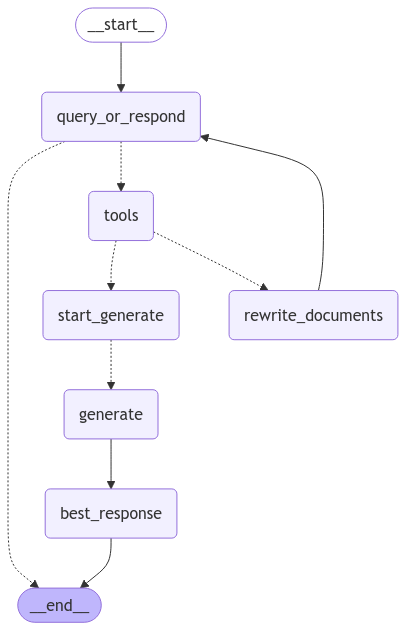

In [144]:
from IPython.display import Image, display

Image(graph.get_graph(xray=1).draw_mermaid_png())


In [131]:
input_message = "Hello"

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello
================================== Ai Message ==================================

Hello! How can I assist you today?


In [149]:
input_message = ("About what this paper?")

for step in graph.stream(
    {"messages": [{"role": "user", "content": input_message}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

About what this paper?
================================== Ai Message ==================================
Tool Calls:
  retrieve (call_HYxgyEtNLkZbqFXJ2ikGNuM0)
 Call ID: call_HYxgyEtNLkZbqFXJ2ikGNuM0
  Args:
    query: About this paper
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'data/AML_IEEE_ACCESS_2024.pdf', 'page': 0}
Content: 2024 The Authors. This work is licensed under a Creative Commons Attribution-NonCommercial-NoDerivatives 4.0 License.
For more information, see https://creativecommons.org/licenses/by-nc-nd/4.0/ VOLUME 12, 2024

Source: {'source': 'data/AML_IEEE_ACCESS_2024.pdf', 'page': 15}
Content: of an AML model. Nevertheless, we hope the approach
presented in this paper will make non-trivial contributions
and give network security and financial crime analysis some
insights into how to employ semi-supervised graph learnin